## Imports

In [1]:
import galsim
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib_scalebar.scalebar import PIXEL_LENGTH
# import matplotlib.cm as cm

## Functions

In [2]:
def draw_gal(p): 

    # super conservative GSParams (they help!)
    gsp = galsim.GSParams(
        folding_threshold=1e-15,
        stepk_minimum_hlr=200,
        maxk_threshold=1e-15,
        kvalue_accuracy=1e-15,
        xvalue_accuracy=1e-15,
        realspace_abserr=1e-15,
        realspace_relerr=1e-15,
        integration_abserr=1e-15,
        integration_relerr=1e-15,
        shoot_accuracy=1e-15
    )

    # create the image for drawing the galaxy into
    image = galsim.ImageF(p.image_size_x,p.image_size_y)

    # create a galaxy
    gal = galsim.Gaussian(flux=p.flux_ADU,half_light_radius=p.gal_hlr,gsparams=gsp)

    # add ellipticity info to galaxy
    gal = gal.shear(g1=p.e1,g2=p.e2)

    # if needed, create psf and add its effect to the image
    if p.psf_fwhm is not None and p.psf_fwhm!=0:
        psf = galsim.Gaussian(flux=1.,fwhm=p.psf_fwhm,gsparams=gsp).shear(g1=0,g2=0) # circular PSF
        # convolve galaxy with psf
        gal = galsim.Convolve([gal, psf],gsparams=gsp)

    # draw image
    image_gal = gal.drawImage(image,scale=p.pixel_scale,method='fft')

    # if needed, add noise
    if p.sky_level is not None:
        random_seed = 1234567890
        rng = galsim.BaseDeviate(random_seed)
        image_gal.addNoise(galsim.PoissonNoise(rng=rng,sky_level=p.sky_level))

    # draw the final image
    fig = plt.figure(figsize=(10,7))
    plt.imshow(image_gal.array,origin='lower') #,cmap=cm.gray)
    plt.title(p.title,fontsize=18)
    plt.xlabel('pixels',fontsize=14)
    plt.ylabel('pixels',fontsize=14)
    plt.colorbar(label='ADU')
    if p.clim is not None: plt.clim(p.clim)
    scalebar = ScaleBar(1,'px', PIXEL_LENGTH, location='lower right',
                    frameon=False, fixed_value=p.scalebar_value/p.pixel_scale,
                    label_formatter = lambda x, y: str(p.scalebar_value)+'\'\'',
                    height_fraction=0.006, color=p.scalebar_color) 
    plt.gca().add_artist(scalebar)      
    return image_gal.array

def ab2adu(magAB,p):
    # converts AB mag to ADU
    # see https://github.com/ismael2395/WLD/blob/7d7194cd37d55a30bd2710b8fc1cf1b0075949a8/descwl/survey.py
    airmass = 1.0 
    airmass0 =1.3 # for DES
    magAB += p.extinction*(airmass-airmass0)
    return p.expt*p.zp*10**(-0.4*(magAB-24))

def Qij(i,j,A,mu,c,Sigma,axis=None):
    # if you input A, mu and Sigma of more than one galaxy it finds their combined moment
    delta = np.radians(c[1]) # declination of the centroid in radians
    cosd = np.cos(delta)
    cf = cosd if i!=j else cosd**2 if i==j==1 else 1.0
    i,j = i-1, j-1
    Qij = np.sum( A*(Sigma.T[:][i][j]+(mu[i]-c[i])*(mu[j]-c[j])*cf), axis=axis )
    Qij = Qij/np.sum(A, axis=axis)
    return Qij

def get_covmat(gamma1,gamma2,gsize): 
    gamma = np.sqrt(gamma1**2+gamma2**2)
    # gsize = FLUX_RADIUS in arcsec
    sigma_round = gsize/3600/np.sqrt(2.*np.log(2)) # degrees
    # a and b imply deviations from a circle of radius R = sigma_round
    a = sigma_round * np.sqrt((1+gamma)/(1-gamma)) # wrong: a = sigma_round /(1-gamma)
    b = sigma_round * np.sqrt((1-gamma)/(1+gamma)) # wrong: b = sigma_round /(1+gamma)
    theta = 0.5*np.arctan2(gamma2,gamma1) # radians!
    N = theta.size
    if N==1:
        R = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
        Sigma_0 = np.array([[a**2,0],[0,b**2]])
        Sigma   = np.dot(R,np.dot(Sigma_0,R.T))
    else:
        R = [np.array([[np.cos(theta[k]),-np.sin(theta[k])],[np.sin(theta[k]),np.cos(theta[k])]]) for k in range(N)]
        Sigma_0 = [np.array([[a[k]**2,0],[0,b[k]**2]]) for k in range(N)]
        Sigma   = [np.dot(R[k],np.dot(Sigma_0[k],R[k].T)) for k in range(N)]
    return np.array(Sigma)

def get_shape(A,mu,c,gamma1,gamma2,gsize):
    Sigma = get_covmat(gamma1,gamma2,gsize)
    Q11 = Qij(1,1,A,mu,c,Sigma) 
    Q12 = Qij(1,2,A,mu,c,Sigma)
    Q22 = Qij(2,2,A,mu,c,Sigma) 
    # epsilon-ellipticity, not chi-ellipticity!
    g1_sys = (Q11-Q22)/(Q11+Q22+2*(Q11*Q22-Q12**2)**0.5)
    g2_sys = 2.0*Q12/(Q11+Q22+2*(Q11*Q22-Q12**2)**0.5)
    mom_size = 3600*(Q11*Q22-Q12**2)**0.25 # in arcsec
    return g1_sys, g2_sys, mom_size

def convolve_with_PSF(A,gamma1,gamma2,gsize,PSF_FWHM=0):
    PSF_size = PSF_FWHM/2 # only true for Gaussians
    Sigma = get_covmat(gamma1,gamma2,gsize)
    Sigma_PSF = get_covmat(0,0,PSF_size) # 0, 0 for circular
    mu, c = np.array([0,0]), np.array([0,0]) 
    Q11 = Qij(1,1,A,mu,c,Sigma)
    Q22 = Qij(2,2,A,mu,c,Sigma)
    Q12 = Qij(1,2,A,mu,c,Sigma)
    A_psf = 1 # apparently it does not affect my Qij calculation since I will normalize
    P11 = Qij(1,1,A_psf,mu,c,Sigma_PSF) 
    P22 = Qij(2,2,A_psf,mu,c,Sigma_PSF)
    P12 = Qij(1,2,A_psf,mu,c,Sigma_PSF) # 0 circular!    
    Q11 += P11        
    Q22 += P22        
    Q12 += P12       
    # epsilon-ellipticity, not chi-ellipticity!
    g1_sys = (Q11-Q22)/(Q11+Q22+2*(Q11*Q22-Q12**2)**0.5)
    g2_sys = 2.0*Q12/(Q11+Q22+2*(Q11*Q22-Q12**2)**0.5)
    mom_size = 3600*(Q11*Q22-Q12**2)**0.25 # in arcsec 
    return g1_sys, g2_sys, mom_size

# idea from stackoverflow.com/questions/2352181/how-to-use-a-dot-to-access-members-of-dictionary
class DotDict(defaultdict):    
#     def __init__(self): # uncommenting this part disables copying
                          # functionality but enables hierarchical 
                          # dot notation access to dictionary variables (fix it)
#         super(DotDict, self).__init__(DotDict)
                          # note that the syntax changed in Python 3.0:
                          # you can just say super().__init__()
    def __getattr__(self, key):
        try:
            return self[key]
        except KeyError:
            raise AttributeError(key)
    def __setattr__(self, key, value):
        self[key] = value

# Main program

### Values

In [3]:
p0 = DotDict()

# -------------
# survey info
# -------------

p0.pixel_scale = 0.263                  # DES Pixel scale in arcsec/pixel
p0.zp = 13.94                           # in ADU for a 24th DES i-mag object and airmass=1.3
p0.expt = 1000.                         # exposure time in sec (DES i-band)
p0.extinction = 0.05                    # MilkyWay extinction (DES i-band)
# sky_brightness = 20.5                  # in AB mag/arcsec^2 (DES i-band)
# p.sky_level = ab2adu(sky_brightness,p) # in ADU/arcsec^2
# p.sky_level *= p.pixel_scale**2        # in ADU/pixel
p0.sky_level = None                     # None for a noise-free image

# -------------
# galaxy info
# -------------

p0.gal_hlr = 2.0                        # half light radious in arcsec
p0.e1, p0.e2 = -0.25, 0.4               # galaxy shapes (epsilon-ellipticities)
p0.psf_fwhm = 2.5                       # in arcsec
imag = 18.7                             # galaxy AB mag (DES i-band); extinction-corrected
p0.flux_ADU = ab2adu(imag,p0)           # flux in ADU

# -------------
# plotting
# -------------

p0.image_size_x = 64                    # postage stamp size: x
p0.image_size_y = 64                    # postage stamp size: y
p0.clim = [0,7000]                      # colorbar limits
p0.scalebar_value = 2                   # scalrbar width in the images in arcsec
p0.scalebar_color = 'white'             # scalrbar color in the images

### PSF convolution: analytic vs. galsim

#### Original image

-0.25 0.4 -0.25 0.4
1.69864360058 1.69864360058


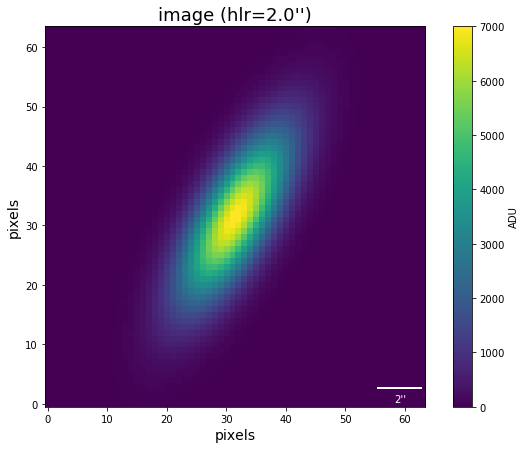

In [4]:
# only assign the variables that are different
p0.psf_fwhm=0
p0.title='image (hlr='+str(p0.gal_hlr)+'\'\')'

e1, e2, mom_size = get_shape(1,np.array([0,0]),np.array([0,0]),p0.e1,p0.e2,p0.gal_hlr)

gal_sigma = p0.gal_hlr/np.sqrt(2.*np.log(2))
print(e1, e2, p0.e1, p0.e2) 
print(mom_size, gal_sigma)

array_original = draw_gal(p0)

#### GalSim-convolved image

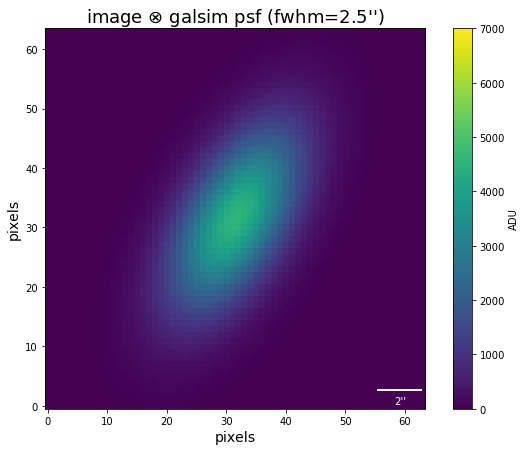

In [5]:
p1 = p0.copy()

p1.psf_fwhm=2.5
p1.title='image $\otimes$ galsim psf (fwhm='+str(p1.psf_fwhm)+'\'\')'

array_galsim_conv = draw_gal(p1)

#### Analitically-convolved image

2.48438628867 2.35849528301


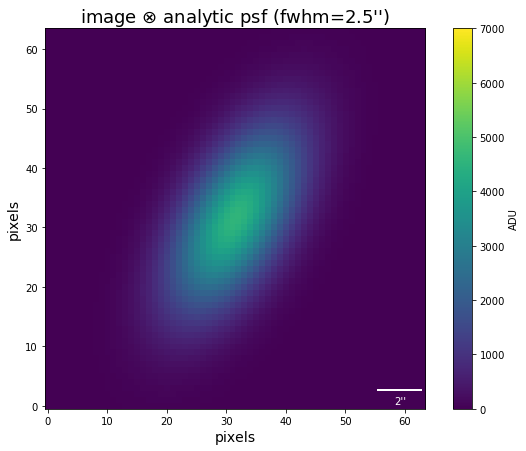

In [6]:
p2 = p0.copy()
# so p2.psf_fwhm = 0 because we apply psf analytically beforehand

psf_fwhm = 2.5 # to be applied analytically
p2.title=r'image $\otimes$ analytic psf (fwhm='+str(psf_fwhm)+'\'\')'
psf_hlr = psf_fwhm/2.0 # true for gaussians
p2.e1, p2.e2, mom_size_conv = convolve_with_PSF(1,p0.e1,p0.e2,
                                        p0.gal_hlr,PSF_FWHM=psf_fwhm)

gal_hlr = (p0.gal_hlr**2+psf_hlr**2)**0.5 # convolved gal_hlr
p2.gal_hlr = mom_size_conv*np.sqrt(2.*np.log(2))
print(p2.gal_hlr, gal_hlr) # they are not exactly the same!

array_analytic_conv = draw_gal(p2)

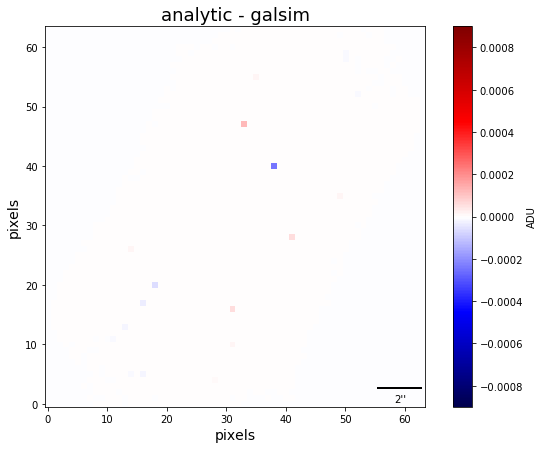

In [7]:
# draw the difference
fig = plt.figure(figsize=(10,7))
plt.imshow((array_analytic_conv - array_galsim_conv),origin='lower',cmap='seismic',vmin=-9e-4,vmax=9e-4)
plt.title('analytic - galsim',fontsize=18)
plt.xlabel('pixels',fontsize=14)
plt.ylabel('pixels',fontsize=14)
plt.colorbar(label='ADU')

scalebar = ScaleBar(1,'px', PIXEL_LENGTH, location='lower right',
                    frameon=False, fixed_value=p0.scalebar_value/p0.pixel_scale,
                    label_formatter = lambda x, y: str(p0.scalebar_value)+'\'\'',
                    height_fraction=0.006, color='black') 
plt.gca().add_artist(scalebar)

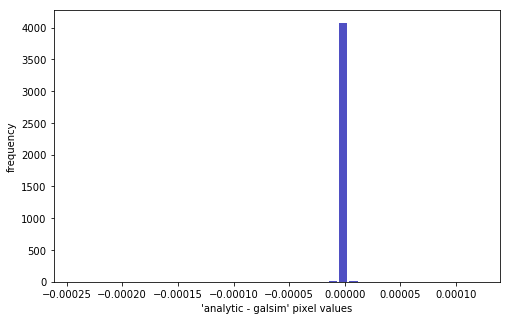

In [8]:
fig = plt.figure(figsize=(8,5))
difference_vector = (array_analytic_conv - array_galsim_conv).flatten()
n, bins, patches = plt.hist(x=difference_vector, bins=40,
                            color='#0504aa',alpha=0.7, rwidth=0.85)
plt.xlabel('\'analytic - galsim\' pixel values')
plt.ylabel('frequency')